<a href="https://colab.research.google.com/github/priyalpote/timeSeriesAnalysis/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima

# Load and prepare Data

From Airpessanger dataset

In [3]:
pd.read_csv('https://raw.githubusercontent.com/priyalpote/timeSeriesAnalysis/main/Data/data/AirPassengers.csv')

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


# Prepare Data

In [4]:
df =  pd.read_csv('https://raw.githubusercontent.com/priyalpote/timeSeriesAnalysis/main/Data/data/AirPassengers.csv', parse_dates=['Month'], index_col=['Month'])
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# Describe the Data

In [5]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


Plot data

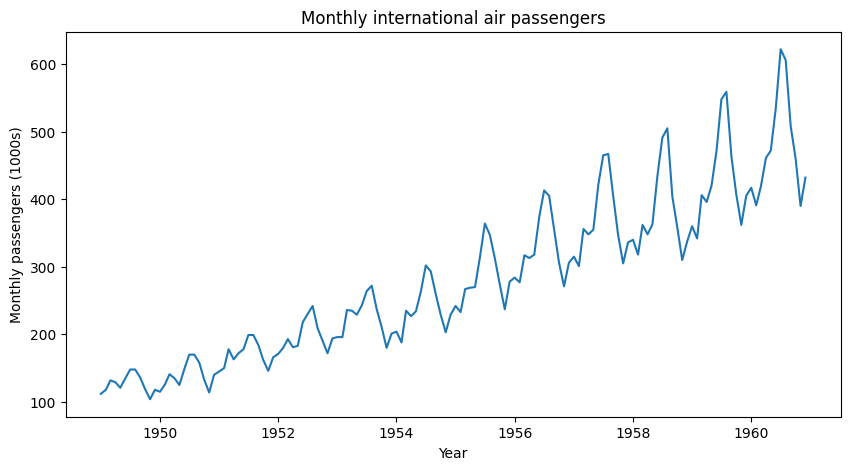

In [16]:

plt.figure(figsize=(10, 5))
plt.plot(df)
plt.xlabel('Year')
plt.ylabel('Monthly passengers (1000s)')
plt.title('Monthly international air passengers')
plt.show()


# Decompose time series
period = months

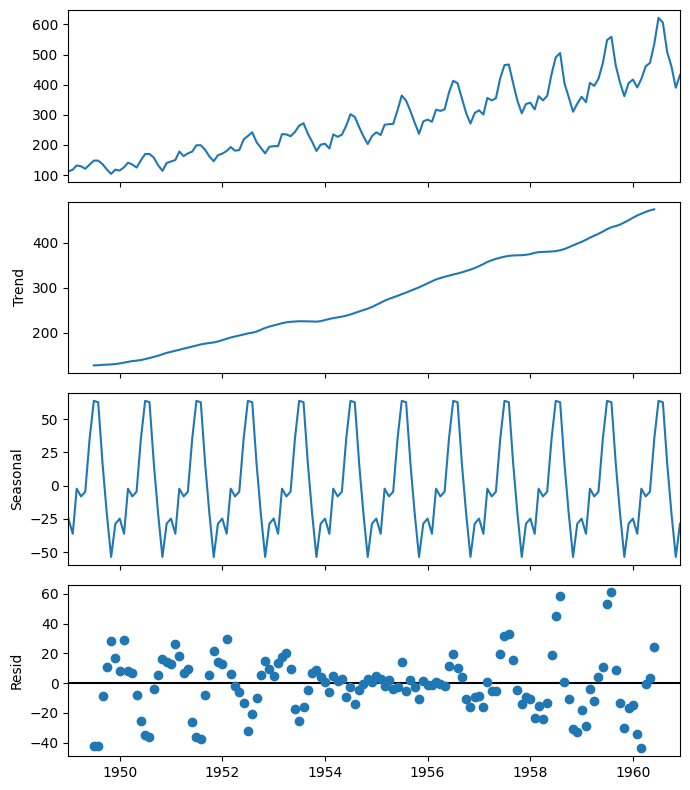

In [11]:
#set the figure size
plt.rcParams['figure.figsize']=[7,8]

#plot the decomposition components
sd= seasonal_decompose(df, period=12).plot()

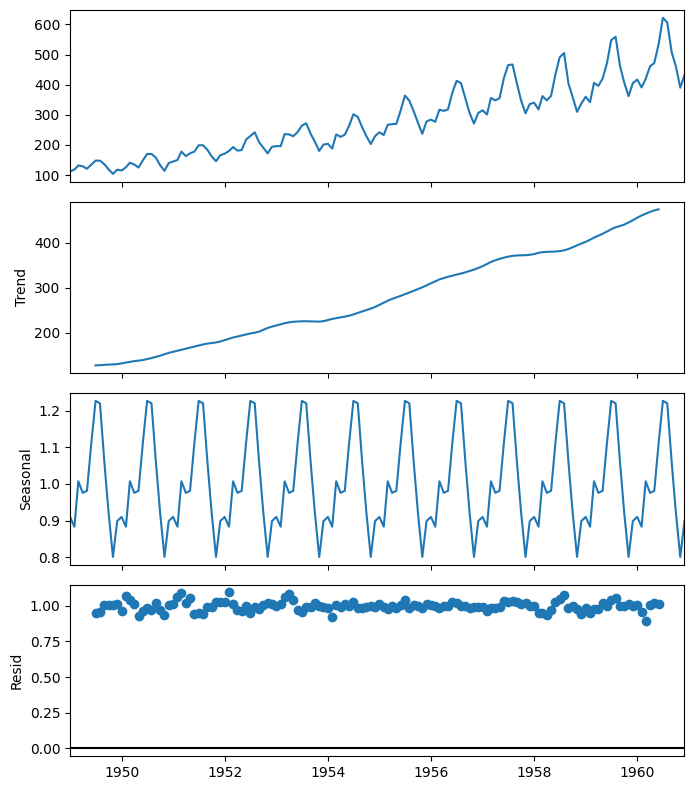

In [13]:
sd =  seasonal_decompose(df,model='multiplicative').plot()

# ARIMA
need to install arima

In [14]:
#pip install pmdarima
import sys
!{sys.executable} -m pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.5 MB/s eta 0:00:00


# Split Data


In [25]:

trn = df[df.index < '1958-01-01']
tst = df[df.index >= '1958-01-01']


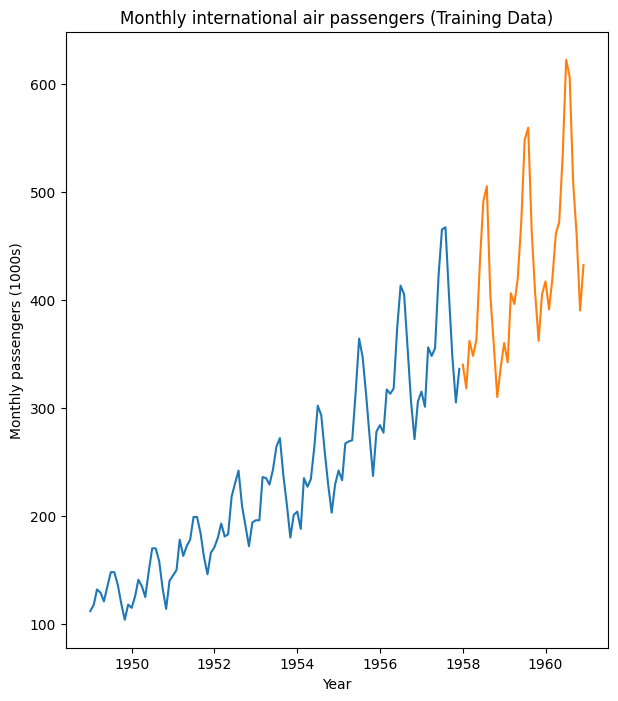

In [26]:

fig, ax = plt.subplots()
plt.plot(trn)
plt.plot(tst)
plt.xlabel('Year')
plt.ylabel('Monthly passengers (1000s)')
plt.title('Monthly international air passengers (Training Data)')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))


# Prepare Model
Test stationary

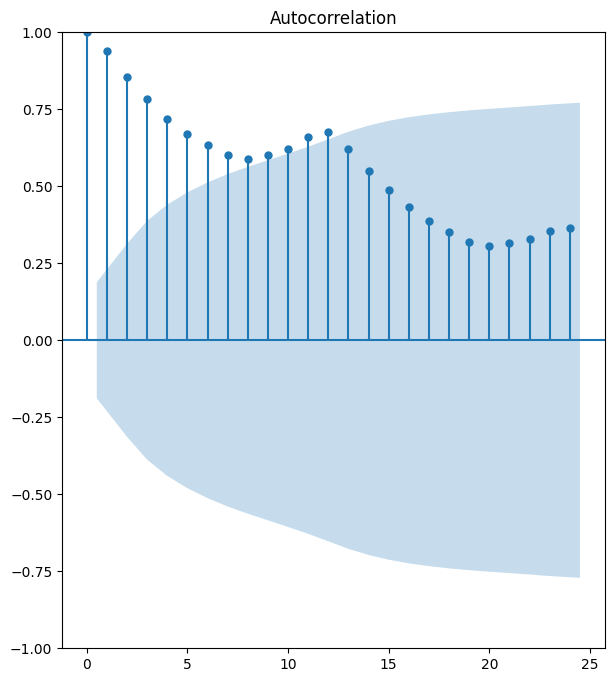

In [27]:
trn.acf= plot_acf(trn, lags=24)

# Linear Model

In [32]:
lr = sm.OLS(endog=trn['#Passengers'], exog=sm.add_constant(np.arange(1,1+trn.shape[0]))).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:            #Passengers   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     526.7
Date:                Thu, 15 Feb 2024   Prob (F-statistic):           6.40e-43
Time:                        04:56:54   Log-Likelihood:                -536.80
No. Observations:                 108   AIC:                             1078.
Df Residuals:                     106   BIC:                             1083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.0422      6.820     13.936      0.0

In [33]:
y_hat = lr.fittedvalues

In [35]:
y_ci =  lr.get_prediction().conf_int(alpha=0.05)

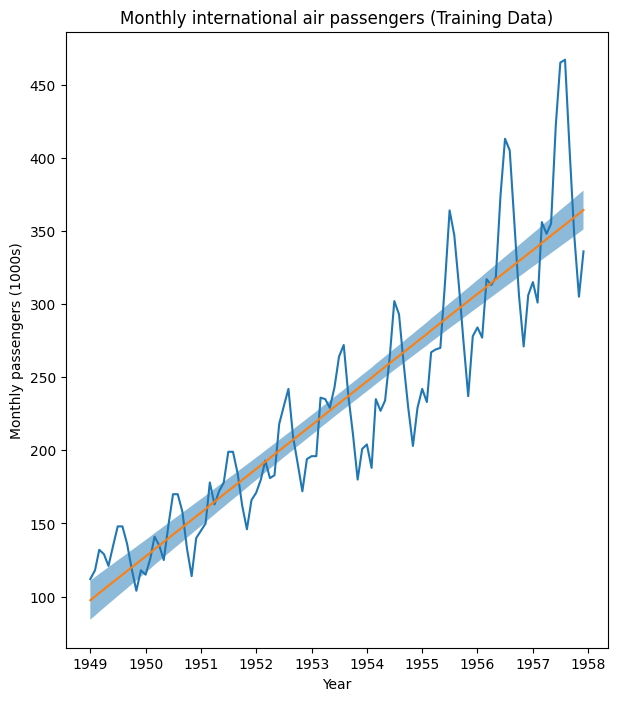

In [36]:
fig, ax = plt.subplots()
plt.plot(trn, label='training data')
plt.plot(y_hat, label='linear regression line')
plt.xlabel('Year')
plt.ylabel('Monthly passengers (1000s)')
plt.title('Monthly international air passengers (Training Data)')
plt.fill_between(y_hat.index, y_ci[:,0],y_ci[:,1],alpha=0.5 , label = '95% conf int')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))


# ARIMA train model

In [42]:
auto_arima_model = auto_arima(trn, m=12, with_intercept=False, suppress_warnings=True)
print(auto_arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -350.001
Date:                            Thu, 15 Feb 2024   AIC                            704.001
Time:                                    05:06:45   BIC                            709.109
Sample:                                01-01-1949   HQIC                           706.065
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439   

In [44]:
auto_arima_model.order

(1, 1, 0)

In [45]:
auto_arima_model.seasonal_order

(0, 1, 0, 12)

In [46]:
resid= auto_arima_model.resid

AxisError: axis 0 is out of bounds for array of dimension 0

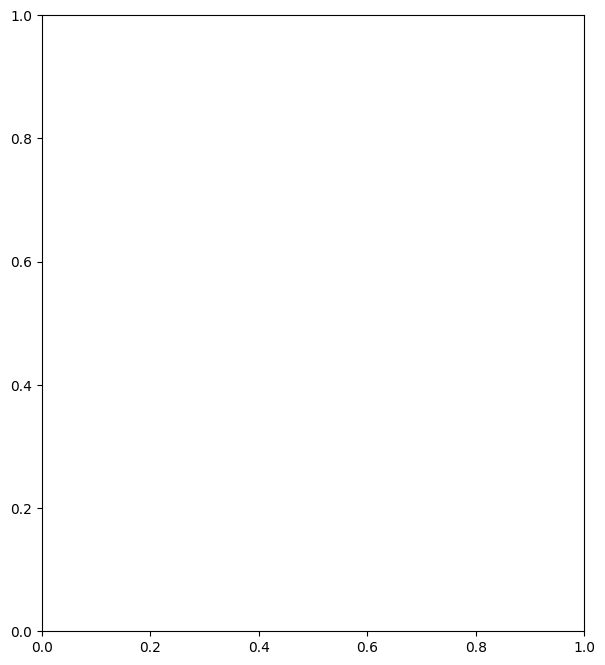

In [47]:
fig, ax = plt.subplots()
plt.plot(trn.index,stats.zscore(resid))
plt.xlabel('Year')
plt.title('Standard resciduals')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))